# Ambient Noise Cross-Correlation Analysis using NoisePy with SeaDAS DAS Data

## Overview

1. ✅ **Cross-correlation processing**: Computed ambient noise correlations from SeaDAS data
2. ✅ **Shot Gather Visualization**: Create shot gather display for wave propagation analysis
3. ✅ **Dispersion analysis**: Extracte frequency-velocity relationships from surface waves

This notebook demonstrates ambient noise cross-correlation analysis using Distributed Acoustic Sensing (DAS) data from the SeaDAS dataset.

### Ambient Noise Cross-Correlation
Ambient noise cross-correlation is a powerful seismological technique that extracts coherent signals (particularly surface waves) from the ambient noise field. By cross-correlating continuous noise recordings between pairs of sensors, we can recover the empirical Green's function between those locations, effectively creating virtual seismic sources. Traditionally, the cross-correlations are done between seismometers, but for DAS we cross-corelate DAS channels.

### Distributed Acoustic Sensing (DAS)
DAS technology converts fiber-optic cables into dense arrays of strain sensors, providing unprecedented spatial resolution for seismic monitoring. Each channel along the fiber acts as a virtual seismometer, enabling detailed analysis of wave propagation and subsurface structure.

### SeaDAS Dataset
We use SEADAS data-set, a dark fiber (telecommunication fiber which is currently not used for data transmission), between two campuses of the University of Washington (UW). The fiber follow mainly streets from the Seattle campus to the Bothell campus. The fiber sectction between channel 1100 and 1700, where tha amplitudes are much higher, the cable is not burried and instead at telephone poles. The vertical lines arre called common noise and are a specific type of instrument noise. The diagonal lines are cars. Figure credit: *Ni et al. 2023*

![title](./seadas_overview.png)

## Dependencies and Environment Setup

This cell configures the Python environment and imports all necessary libraries for DAS data processing and ambient noise cross-correlation analysis.

**Key Libraries:**
- **NoisePy**: Specialized library for ambient noise cross-correlation analysis
    - **GitHub**: https://github.com/noisepy/NoisePy
    - **Documentation**: https://noisepy.readthedocs.io/en/latest/
    - **Paper**: [Jiang and Denolle, 2020](https://pubs.geoscienceworld.org/ssa/srl/article/95/1/499/628716), [Ni et al., 2023](https://pubs.geoscienceworld.org/ssa/srl/article/95/1/499/628716)
- **h5py**: For reading HDF5 format DAS data files

In [ ]:
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level=logging.WARNING)

import os
# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import numpy as np
import h5py
import matplotlib.pyplot as plt

from noisepy.seis.io.h5store import DASH5DataStore
from datetime import datetime, timezone
from datetimerange import DateTimeRange
from noisepy.seis.io.datatypes import CCMethod, ConfigParameters, FreqNorm, RmResp, StackMethod, TimeNorm, Channel
from noisepy.seis.io.numpystore import NumpyCCStore
from noisepy.seis.io.asdfstore import ASDFStackStore

from noisepy.seis import cross_correlate, stack_cross_correlations, __version__  

## Data Selection and Time Range Configuration

Here we define the specific dataset, time window, and spatial extent for our analysis.

**Dataset Selection:**
- **Data Source**: SeaDAS DAS recordings from February 2023
- **Time Window**: 1-hour analysis window (00:00-01:00 UTC on Feb 1, 2023)
- **Spatial Extent**: Channels 500-750 (250 channels total)

**Important Note:**
For rigorous scientific analysis, both spatial and temporal parameters should be significantly increased to improve cross-correlation stacking and enhance signal quality:

- **Extended time windows**: Use days to weeks of continuous data rather than single hours to achieve stable Green's function recovery
- **Larger spatial apertures**: Include more channels (1000+ channels) to improve array resolution and capture longer-wavelength surface waves
- **Longer correlation windows**: Consider increasing cc_len to improve frequency resolution for detailed dispersion analysis

The current parameters are optimized for computational efficiency and demonstration purposes, but production-quality ambient noise analysis requires substantially more data for robust scientific conclusions.


In [ ]:
DAS_DATA = "../../data/manuela/"

# timeframe for analysis
start = datetime(2023, 2, 3, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2023, 2, 3, 1, 0, 0, tzinfo=timezone.utc)
time_range = DateTimeRange(start, end)
print(time_range)

# space of interesst (channels)
cha_start = 500
cha_end = 750 + 1 # one more than interessted
cha_step = 1
channel_list = list(np.arange(cha_start,cha_end, cha_step))

2023-02-03T00:00:00+0000 - 2023-02-03T01:00:00+0000


## DAS Data File Inspection and Metadata Extraction

This section examines a DAS data file to understand the acquisition parameters and data structure.

**Key Metadata Parameters:**
- **Gauge Length**: The length of fiber that is interrogated for each measurement point
- **Spatial Sampling**: Distance between consecutive measurement points along the fiber
- **Sampling Rate**: Temporal sampling frequency of the DAS system
- **Cable Geometry**: Total number of channels and cable length


In [ ]:
file = DAS_DATA + "seadasn_2023-02-03_00-00-00_GMT.h5"
with h5py.File(file,'r') as f:
    gauge_len = f['Acquisition'].attrs['GaugeLength']
    delta_space = f['Acquisition'].attrs['SpatialSamplingInterval']
    sample_rate  = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    num_channel = f['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    num_sample  = len(f['Acquisition']['Raw[0]']['RawDataTime'][:])
    minute_data = f['Acquisition']['Raw[0]']['RawData'][:,:]

delta_time = 1.0 / sample_rate

date = file.split('_')[1]
time = file.split('_')[2]

print(f'UTC: {date} {time}')
print('-'*24)
print(f'1-min data with shape: {minute_data.shape}')
print('-'*24)
print(f'Gauge length (m): {gauge_len}')
print(f'Channel spacing (m): {delta_space}')
print(f'Number of channels: {num_channel}')
print(f'Total cable length (m): {delta_space * num_channel}')
print('-'*24)
print(f'Sampling rate (Hz): {sample_rate}')
print(f'Number of samples in file: {num_sample}')
print(f'Total duration (s): {delta_time * num_sample:.2f}')

UTC: 2023-02-03 12-00-00
------------------------
1-min data with shape: (12000, 2089)
------------------------
Gauge length (m): 9.571428805203961
Channel spacing (m): 4.785714402601981
Number of channels: 2089
Total cable length (m): 9997.357387035538
------------------------
Sampling rate (Hz): 200.0
Number of samples in file: 12000
Total duration (s): 60.00


## Initialize DAS Data Store for NoisePy Processing

The DASH5DataStore is NoisePy's interface for reading DAS data in HDF5 format. This creates a standardized data access layer that handles:

**Data Store Configuration:**
- **File naming pattern**: Defines how to parse timestamps from filenames
- **Array identification**: Associates data with the specific DAS array ("SeaDAS")
- **Channel selection**: Limits processing to our region of interest
- **Time filtering**: Ensures only data within our specified time range is accessed

In [4]:
raw_store = DASH5DataStore(path = DAS_DATA,
                           sampling_rate=sample_rate,
                           channel_numbers=channel_list,
                           file_naming = "seadasn_%Y-%m-%d_%H-%M-%S_GMT.h5",
                           array_name = "SeaDAS",
                           date_range = time_range) # Store for reading raw data from S3 bucket
raw_store.fs

## Data Store Validation and Sample Data Access

These cells verify that the data store is properly configured and can access the DAS data:

1. **Time span enumeration**: Lists all available data segments within our time range
2. **Channel verification**: Confirms which channels are available for each time segment  
3. **Sample data read**: Tests actual data access by reading a small sample

**Quality Assurance:**
This step is crucial for identifying potential issues before beginning computationally intensive cross-correlation processing:
- Missing data files
- Corrupted timestamps
- Channel numbering inconsistencies
- File access permission problems

In [7]:
span = raw_store.get_timespans()
channels = raw_store.get_channels(span[0])
d = raw_store.read_data(span[2], channels[0])
d.stream

2025-11-26 16:34:51,239 8563007680 INFO h5store.get_channels(): Getting 251 channels for 2023-02-03T00:00:00+0000 - 2023-02-03T00:01:00+0000


1 Trace(s) in Stream:
SeaDAS.00500..XXZ | 2023-02-03T00:02:00.002100Z - 2023-02-03T00:02:59.997100Z | 200.0 Hz, 12000 samples

## Output Directory Configuration

**Important Note**: NoisePy skips processing if output files already exist. This prevents accidental overwriting but requires careful directory management.

**Directory Structure:**
- **Main path**: `/wd1/manuela_data/SEADAS_4` - Root directory for this analysis
- **CCF subdirectory**: Stores cross-correlation function results
- **STACK subdirectory**: Contains stacked (averaged) cross-correlations


In [9]:
# ⛔️ data will be skipped if already existing -> delete previous run or create new folder
path = "./output_seadas" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")

## Cross-Correlation Configuration Parameters

This configuration defines all parameters for ambient noise cross-correlation processing. Each parameter group serves a specific purpose in the signal processing pipeline.

### **Temporal Parameters**
- **cc_len (s)**: Length of individual correlation windows - balances frequency resolution with temporal stability
- **step (s)**: Overlap between windows
- **sampling_rate (Hz)**: Can be different from original sampling rate, if so, data will be downsampled

### **Filtering and Noise Preprocessing**  
- **freqmin/freqmax (Hz)**: Bandpass filter focusing on surface wave energy
- **max_over_std ()**: Outlier removal threshold to eliminate transient waves, large value leads to less removal

### **Spectral Normalization**
- **freq_norm**: Applies spectral whitening to enhance coherent signals across all frequencies
    - **RMA**: Running Mean Average, less rigourous than one-bit
    - **NO**: No normalization
- **smoothspect_N (samples)**: Samples to be smoothed for running-mean average (freq-domain)

### **Temporal Normalization**
- **time_norm**: Removes amplitude variations while preserving phase information
    - **ONE-BIT**: In time domain, sets positive amplitudes equals 1, and negative amplitudes equals -1
    - **RMA**: Running Mean Average, less rigourous than one-bit
    - **NO**: No normalization
- **smooth_N (samples)**: Samples to be smoothed for running-mean average (time-domain)

### **Cross-Correlation Method**
- **cc_method**: Method
    - **XCORR**: Cross-correlation
    - **DECONV**: Deconvolution

- **maxlag (s)**: Lag window to be saved (captures both causal and acausal parts of Green's function)


In [10]:
config = ConfigParameters()
config.start_date = start
config.end_date = end
config.acorr_only = False # only perform auto-correlation or not
config.xcorr_only = True # only perform cross-correlation or not

config.inc_hours = 0
config.sampling_rate = 200  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 60  # (int) basic unit of data length for fft (sec)
config.step= 60.0  # (float) overlapping between each cc_len (sec)

config.ncomp = 1  # 1 or 3 component data (needed to decide whether do rotation)

config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
      # If True, the stationXML file is assumed to be provided.
config.rm_resp= RmResp.NO  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',

############## NOISE PRE-PROCESSING ##################
config.freqmin,config.freqmax = 1., 20.0  # broad band filtering of the data before cross correlation
config.max_over_std  = 10*9  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

################### SPECTRAL NORMALIZATION ############
config.freq_norm= FreqNorm.RMA  # choose between "rma" for a soft whitening or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 1  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

#################### TEMPORAL NORMALIZATION ##########
config.time_norm = TimeNorm.ONE_BIT # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
config.smooth_N= 100  # moving window length for time domain normalization if selected (points)

############ cross correlation ##############
config.cc_method= CCMethod.XCORR # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

config.substack = False  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_windows = 1  # how long to stack over (for monitoring purpose): need to be multiples of cc_len

config.maxlag= 5  # lags of cross-correlation to save (sec)

config.networks = ["*"]

## Channel Pair Filtering Strategy

These functions implement a custom channel pairing strategy for cross-correlation analysis. Rather than computing correlations between all possible channel pairs (which would be computationally prohibitive), select a source and some receiver channels.

### **One-sided Virtual Source Approach**
NoisePy normally correlates all stations with each other. To speed it up and make use of the advantage of DAS, we select one channel as source and 250 following channels as receiver to get a virtual shot gather.

**Function Logic:**
- **Source channel**: Fixed at channel 500 (cha_start)
- **Receiver channels**: All channels from 500 to 750
- **Result**: Creates a "virtual source" at channel 500 with receivers distributed along the cable

In [ ]:
from functools import partial

def pair_filter_oneside(src: Channel, rec: Channel,
                        cha_start: int, cha_end: int) -> bool:

    isrc = int(src.station.name)
    irec = int(rec.station.name)

    return (isrc == cha_start) and (irec <= cha_end)

pair_filter_forward = partial(pair_filter_oneside,
                              cha_start=cha_start,
                              cha_end=cha_end)


## Cross-Correlation Computation

**⚠️ Warning: Verbose Output Expected**

This cell performs the core cross-correlation computation. NoisePy generates extensive logging output during processing, which may overwhelm the notebook interface.

**⚠️ Warning: Expected Runtime**: Several minutes depending on data volume and computational resources. The prepared example (1h, 250 channels takes about 8 minutes)

**Processing Steps:**
1. **Data loading**: Reads DAS data for each time window
2. **Preprocessing**: Applies filtering, normalization, and quality control
3. **Correlation**: Computes cross-correlations for all specified channel pairs
4. **Storage**: Writes results to disk in organized format

**What's Happening Under the Hood:**
- Time series are segmented into cc_len windows
- Each window undergoes spectral and temporal normalization  
- FFT-based correlation computation for efficiency
- Quality control removes windows exceeding thresholds
- Results organized by channel pair and time stamp


In [ ]:
# ⛔️ this is where there are too many logging that overflows the notebook limit
cc_store = NumpyCCStore(cc_data_path) # Store for writing CC data
cross_correlate(raw_store, config, cc_store, pair_filter=pair_filter_forward)

## Cross-Correlation Stacking

Stacking combines multiple cross-correlation measurements to improve signal-to-noise ratio and estimate the empirical Green's function between channel pairs.

**Stacking Methods:**
- **LINEAR**:
- **PWS**: Phase-weighted stacking, *Schimmel and Paulssen, 1997*
- **ROBUST**: *Pavlis amd Vernon, 2010*
- **NROOT**: *Yang et al., 2020*
- **AUTO_COVARIANCE**: *Nakata et al., 2016*
- **SELECTIVE**: *Yang et al., 2020*

**Stacking Process:**
1. **Linear stacking**: Simple averaging of correlation functions (most robust for ambient noise)
2. **Temporal coherence**: Random noise cancels out while coherent signals reinforce
3. **Green's function recovery**: Stacked result approximates the impulse response between channels

In [13]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = NumpyCCStore(cc_data_path, mode="r")
stack_store = ASDFStackStore(stack_data_path)
config.stack_method = StackMethod.LINEAR

2025-11-26 16:43:18,382 8563007680 INFO numpystore.__init__(): store creating at ./output_seadas/CCF, mode=r, storage_options={'client_kwargs': {'region_name': 'us-west-2'}}
2025-11-26 16:43:18,383 8563007680 INFO numpystore.__init__(): Numpy store created at ./output_seadas/CCF


In [ ]:
stack_cross_correlations(cc_store, stack_store, config)

## Results Loading and Analysis Preparation

This section loads the computed cross-correlation results and prepares them for scientific analysis and visualization.

**Data Retrieval:**
- **Station pairs**: Lists all channel combinations that were successfully processed  
- **Bulk reading**: Efficiently loads all stacked cross-correlations
- **Configuration archival**: Saves processing parameters for reproducibility

**Quality Assessment:**
The number of station pairs indicates processing success:
- Expected: ~250 pairs (channels 500-750 with source at 500)
- Fewer pairs may indicate data quality issues or processing failures
- More pairs suggests additional correlations were computed

In [ ]:
pairs = stack_store.get_station_pairs()
print(f"Found {len(pairs)} station pairs")
sta_stacks = stack_store.read_bulk(time_range, pairs) # no timestamp used in ASDFStackStore

# Save the configuration file
config.save_yaml(os.path.join(path, "config.yaml"))

## Cross-Correlation Data Organization for Visualization

This cell transforms the NoisePy results into a format suitable for traditional seismological visualization (shot gather style).

**Data Extraction Process:**
1. **Source-receiver identification**: Extracts channel numbers from station pairs
2. **Distance calculation**: Converts channel separation to physical distance using cable geometry
3. **Source filtering**: Selects only correlations with channel 500 as virtual source
4. **Array organization**: Arranges waveforms by increasing distance from source

**Key Variables:**
- **shots**: 2D array where each row is a cross-correlation waveform
- **offsets**: Distances from virtual source (channel 500) to each receiver
- **lag**: Time axis spanning ±maxlag seconds around zero


In [16]:
# Collect data from sta_stacks
shots = []
offsets = []

for idx, i in enumerate(sta_stacks):
    src = int(i[0][0].name)
    rec = int(i[0][1].name)
    dist = abs(src - rec) * delta_space
    
    if src == cha_start:
        # Append shot and offset
        shots.append(i[1][1].data)  # waveform
        offsets.append(dist)

# Convert to numpy arrays
shots = np.array(shots)
offsets = np.array(offsets)
nx, ns = shots.shape

# Lag times in seconds
lag = np.linspace(-config.maxlag, config.maxlag, ns)

## Shot Gather Visualization of Cross-Correlations

This produces a classic seismological "shot gather" display showing how seismic energy propagates away from the virtual source.

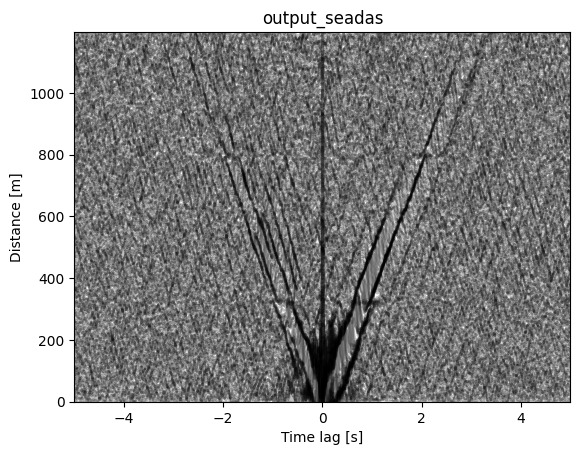

In [ ]:
for ix in range(shots.shape[0]):
    plt.plot(lag, shots[ix]*10000 + offsets[ix], color='k', alpha=0.25)
plt.title(f'{path.split("/")[-1]}')
plt.xlabel('Time lag [s]')
plt.ylabel('Distance [m]')
plt.xlim(-config.maxlag,config.maxlag)
plt.ylim(0,offsets.max())
plt.show()
# plt.savefig(os.path.join(path, "shot_gather_stacked_ccf.png"), dpi=300)

## Surface Wave Dispersion Analysis

This analysis transforms the cross-correlation data into the frequency-phase velocity domain to identify dispersive surface wave modes. The idea is that different frequencies travel at different velocities (they are dispersive). Also, different frequencies sample to different depth, higher frequencies sample shallower depths. As for the cross-correlations, the dominat waves are Rayleigh waves.

### **Mathematical Background**

**Phase Shift Method:**
For each test velocity *v* and frequency *f*, we apply phase corrections:
```
shifted_signal(x,f) = original_signal(x,f) × exp(2πi × f × x/v)
```

Where:
- *x* = distance from virtual source
- *f* = frequency 
- *v* = test phase velocity
- *i* = imaginary unit

**Physical Interpretation:**
- **Correct velocity**: Signals align constructively after phase correction → high amplitude
- **Incorrect velocity**: Signals interfere destructively → low amplitude
- **Dispersion curve**: Ridge of maximum energy traces velocity vs. frequency relationship

### **Processing Steps:**
1. **Velocity grid**: Test 50 velocities from 100-1000 m/s (typical for surface waves)
2. **FFT transformation**: Convert time-domain correlations to frequency domain
3. **Phase correction**: Apply velocity-dependent phase shifts
4. **Coherent stacking**: Average phase-corrected signals across all receivers
5. **Amplitude extraction**: Measure coherent energy for each velocity-frequency pair


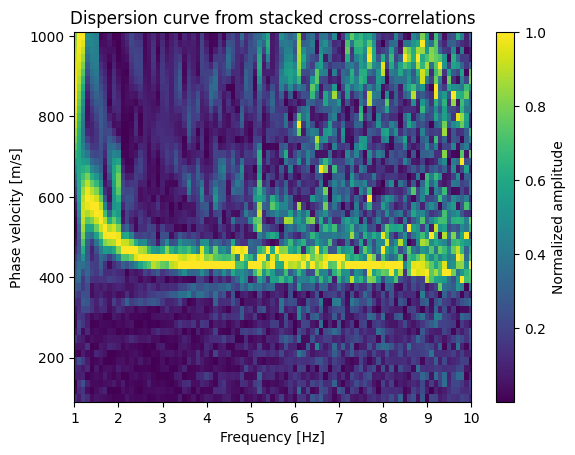

In [ ]:
vs = np.linspace(100, 1000, 50)  # phase velocities to scan

# FFT along time axis
shotf = np.fft.rfft(shots, axis=1)
frq = np.fft.rfftfreq(ns, d=(lag[1]-lag[0]))

# Dispersion calculation
nv = len(vs)
disp = np.zeros((nv, len(frq)))

for iv, v in enumerate(vs):
    shifted = shotf.copy()
    for ix in range(nx):
        shifted[ix, :] *= np.exp(2j * np.pi * frq * offsets[ix] / v)
    disp[iv, :] = np.abs(np.mean(np.real(shifted), axis=0))

# Normalize (optional)
disp /= np.max(disp, axis=0, keepdims=True)

# Plot dispersion curve
plt.pcolormesh(frq, vs, disp, shading='auto')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase velocity [m/s]')
plt.xlim(config.freqmin, config.freqmax*0.5)
plt.colorbar(label='Normalized amplitude')
plt.title('Dispersion curve from stacked cross-correlations')
plt.show()
# plt.savefig(os.path.join(path, "dispersion_curve_stacked_ccf.png"), dpi=300)
